In [17]:
from basic_op_jup import *
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from cdo import Cdo
import bottleneck as bk
import pandas as pd
cdo=Cdo()

In [18]:
file_in_prec = '~/work/jacopo/DATA/ERA5_prec_day_HKKH.nc'
region_prec = cdo.sellonlatbox(78, 93, 25, 32, input = file_in_prec)

prec = xr.open_dataset(region_prec)

to_base = prec.tp.sel(time=slice("1950-01-01", "1980-01-01"))
to_proj = prec.tp.sel(time=slice("1950-01-01", "1960-01-04"))

In [19]:
eof, pc, exp_var, solver = eof_base(to_base = to_base, weights = None, center = True, ddof = 1, eofscaling = 0, pcscaling = 0, n_comp = 3)
pc_projection = eof_project(solver, to_proj, 3)

array([[ 0.45742738,  0.3301906 , -0.0715439 ],
       [-1.4072963 , -1.0060264 ,  0.22478898]], dtype=float32)

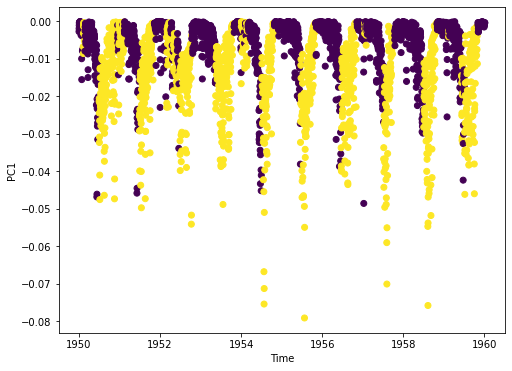

In [20]:
training_set_0 = pc.to_numpy()
train_mvm = bk.move_mean(training_set_0, window = 30, axis = 0)
train_mvm[np.isnan(train_mvm)] = 0
training_set = train_mvm
#training_set = np.concatenate((training_set_0, train_mvm), axis = 1)

test_set_0 = pc_projection.to_numpy()
test_mvm = bk.move_mean(test_set_0, window = 30, axis = 0)
test_mvm[np.isnan(test_mvm)] = 0
test_set = test_mvm
#test_set = np.concatenate((test_set_0, test_mvm), axis = 1)

training_set = training_set/np.std(training_set, axis = 0)
test_set = test_set/np.std(test_set, axis = 0)

model, clust_centers = kmean_training(training_set, 2, 300)
prediction = kmean_preditting(model, test_set)

fig = plt.figure(figsize=(8, 6))
plt.scatter(pc_projection.time, pc_projection.sel(mode=0), c = prediction)
plt.ylabel('PC1')
plt.xlabel('Time')

clust_centers

In [21]:
yr = pc_projection['time.year'].to_numpy()
dd = gregorian_day(pc_projection)

bb = pd.DataFrame(np.transpose(np.vstack((prediction,yr,dd))))

bb.columns = ['idx', 'yr', 'dd']
trend = bb.groupby(["yr",'idx']).mean()
trend_st = bb.groupby(["yr",'idx']).std()

#plt.scatter(trend.reset_index()['yr'], trend.reset_index()['dd'], c=trend.reset_index()['idx'])


Text(0.5, 1.0, 'Time evolution of monsoon-like season - HKK')

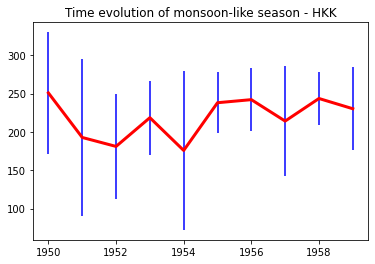

In [22]:
trend_np = np.array(trend.reset_index())
trend_st_np = np.array(trend_st.reset_index())

to_plot = trend_np[trend_np[:,1]==1] 
to_plot_err =  trend_st_np[trend_st_np[:,1]==1] 


plt.errorbar(to_plot[:,0], to_plot[:,2], yerr = to_plot_err[:,2], lw = 3, elinewidth = 1.5, c = 'r', ecolor = 'b')
plt.title('Time evolution of monsoon-like season - HKK')

In [23]:
dd

array([1, 2, 3, ..., 2, 3, 5])

In [24]:
print(pc_projection['time'])

<xarray.DataArray 'time' (time: 3656)>
array(['1950-01-01T15:00:00.000000000', '1950-01-02T11:30:00.000000000',
       '1950-01-03T11:30:00.000000000', ..., '1960-01-02T11:30:00.000000000',
       '1960-01-03T11:30:00.000000000', '1960-01-04T11:30:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1950-01-01T15:00:00 ... 1960-01-04T11:30:00
Attributes:
    standard_name:  time
    bounds:         time_bnds
    axis:           T
